<img src="https://devra.ai/analyst/notebook/2197/image.jpg" style="width: 100%; height: auto;" />

<div style="text-align:center; border-radius:15px; padding:15px; color:white; margin:0; font-family: 'Orbitron', sans-serif; background: #2E0249; background: #11001C; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.3); overflow:hidden; margin-bottom: 1em;">
    <div style="font-size:150%; color:#FEE100"><b>Employee Burnout Analysis and Prediction</b></div>
    <div>This notebook was created with the help of <a href="https://devra.ai/ref/kaggle" style="color:#6666FF">Devra AI</a></div>
</div>

Welcome to this notebook where we explore a synthetic HR burnout dataset. In a world where employee burnout is a creeping crisis, our journey of data exploration and prediction might offer a few insights into the stresses of modern work life. If you find these insights useful, please consider upvoting this notebook.

## Table of Contents
- [Imports and Setup](#Imports-and-Setup)
- [Data Loading and Inspection](#Data-Loading-and-Inspection)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Predictive Modeling](#Predictive-Modeling)
- [Model Evaluation](#Model-Evaluation)
- [Summary and Future Work](#Summary-and-Future-Work)

In [1]:
# Imports and Setup
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Use Agg backend for matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # In case only plt was imported
get_ipython().run_line_magic('matplotlib', 'inline')

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Setting a nice plot style
sns.set(style="whitegrid")

# For reproducibility
np.random.seed(42)

In [2]:
# Data Loading and Inspection
file_path = '/kaggle/input/synthetic-hr-burnout-dataset/synthetic_employee_burnout.csv'
df = pd.read_csv(file_path, encoding='ascii', delimiter=',')

# Show basic structure of the data
print('Data Shape:', df.shape)
print('Columns:', df.columns.tolist())

# A quick peek at the data to build our curiosity
df.head()

Data Shape: (2000, 10)
Columns: ['Name', 'Age', 'Gender', 'JobRole', 'Experience', 'WorkHoursPerWeek', 'RemoteRatio', 'SatisfactionLevel', 'StressLevel', 'Burnout']


,Name,Age,Gender,JobRole,Experience,WorkHoursPerWeek,RemoteRatio,SatisfactionLevel,StressLevel,Burnout
0,Max Ivanov,32,Male,Analyst,3,60,21,4.40,1,0
1,Max Wang,40,Female,Engineer,9,47,67,2.09,2,0
2,Nina Petrov,33,Female,Engineer,2,44,20,2.58,3,0
3,John Ivanov,35,Female,Manager,6,44,70,3.23,8,0
4,John Wang,59,Male,Sales,8,38,46,4.41,1,0


In [3]:
# Data Cleaning and Preprocessing
# Checking for missing values
print('Missing values per column:')
print(df.isnull().sum())

# A bit of dry humor: if missing values are abundant, they might be trying to hide burnout insights.

# Convert dtypes if necessary - in this dataset all columns are provided with expected types
# But we can enforce proper casting if needed
df['Age'] = df['Age'].astype(int)
df['Experience'] = df['Experience'].astype(int)
df['WorkHoursPerWeek'] = df['WorkHoursPerWeek'].astype(int)
df['RemoteRatio'] = df['RemoteRatio'].astype(int)
df['StressLevel'] = df['StressLevel'].astype(int)
df['Burnout'] = df['Burnout'].astype(int)

# For categorical columns, ensure they are of string type
df['Name'] = df['Name'].astype(str)
df['Gender'] = df['Gender'].astype(str)
df['JobRole'] = df['JobRole'].astype(str)

# It is always useful to examine the data types
print(df.dtypes)

Missing values per column:
Name                 0
Age                  0
Gender               0
JobRole              0
Experience           0
WorkHoursPerWeek     0
RemoteRatio          0
SatisfactionLevel    0
StressLevel          0
Burnout              0
dtype: int64
Name                  object
Age                    int64
Gender                object
JobRole               object
Experience             int64
WorkHoursPerWeek       int64
RemoteRatio            int64
SatisfactionLevel    float64
StressLevel            int64
Burnout                int64
dtype: object


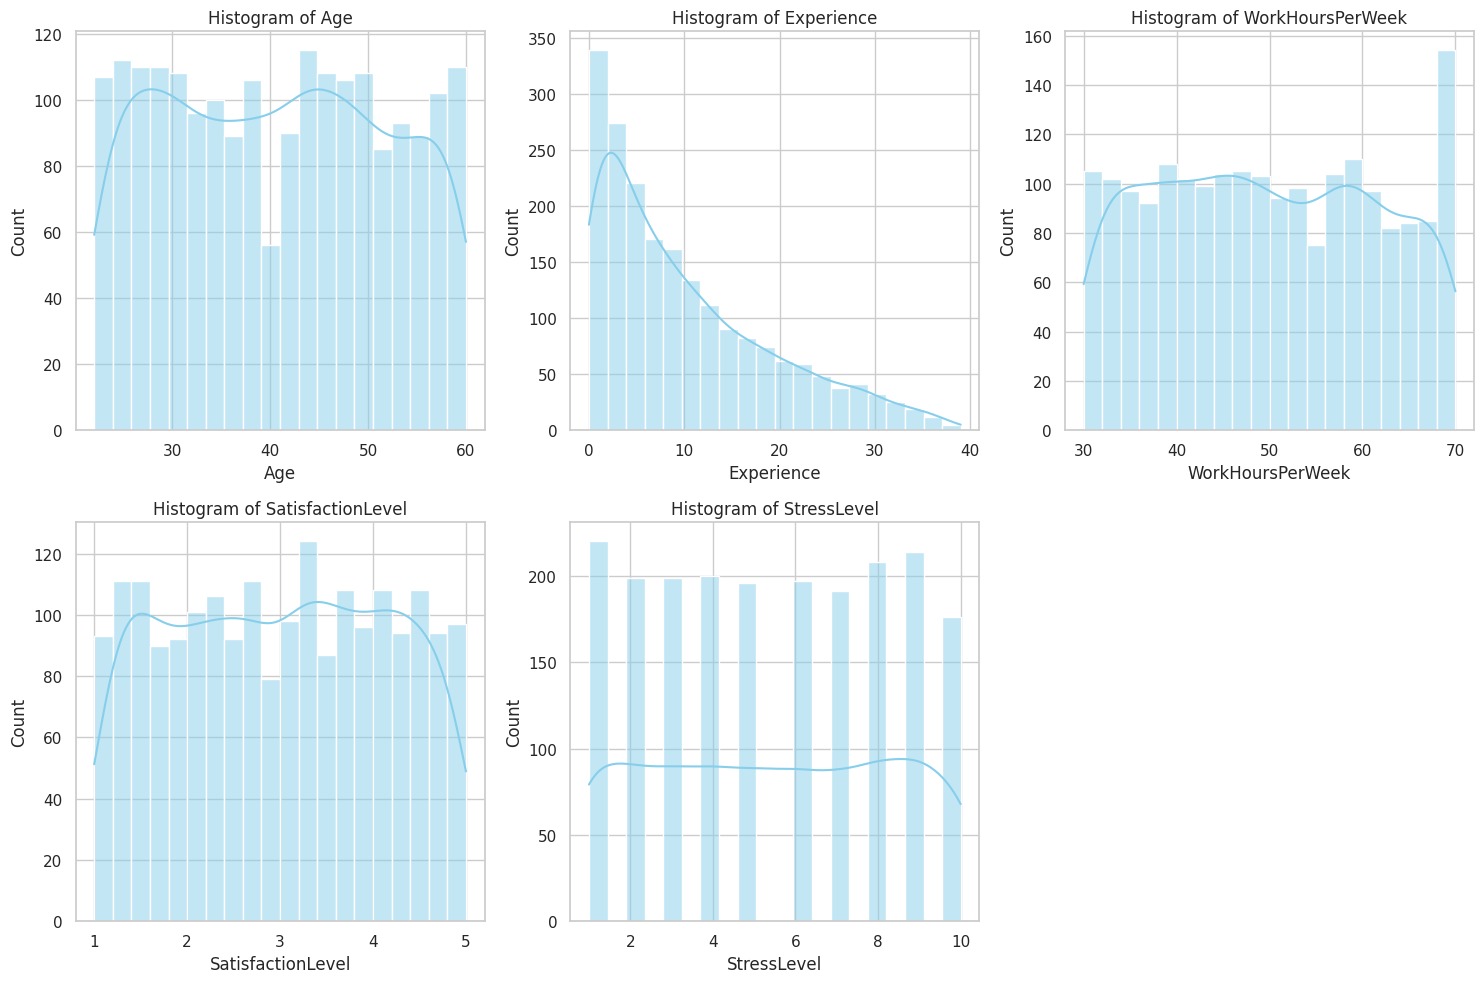

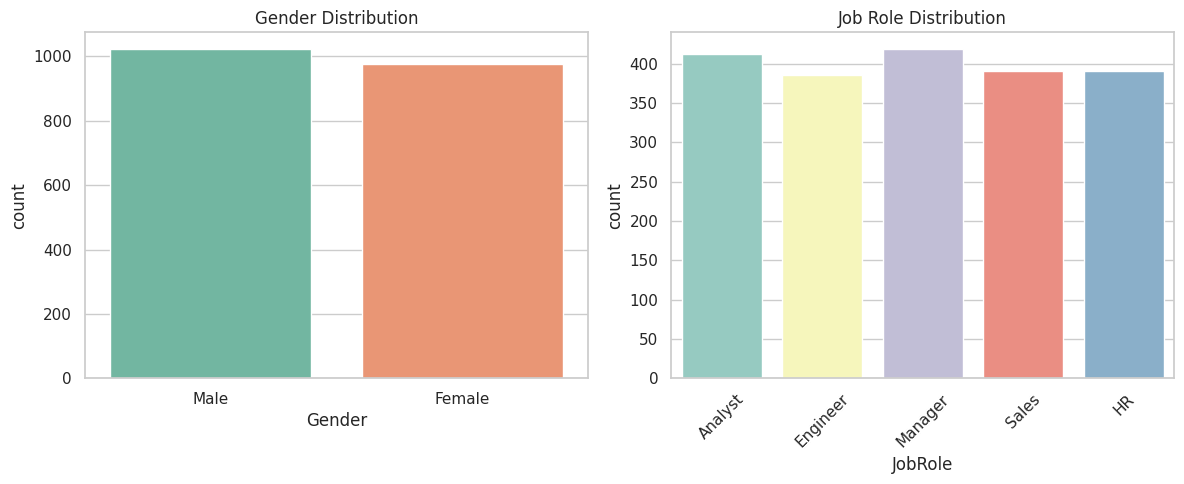

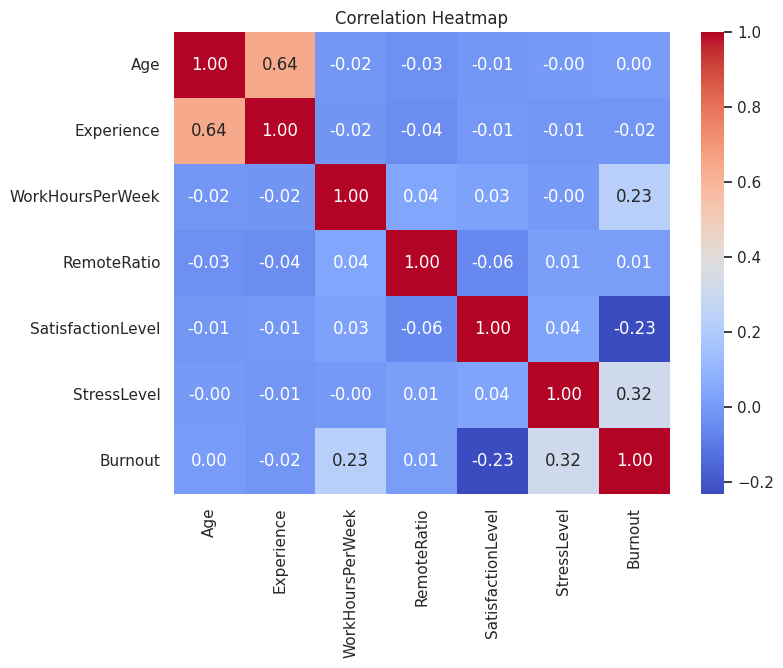

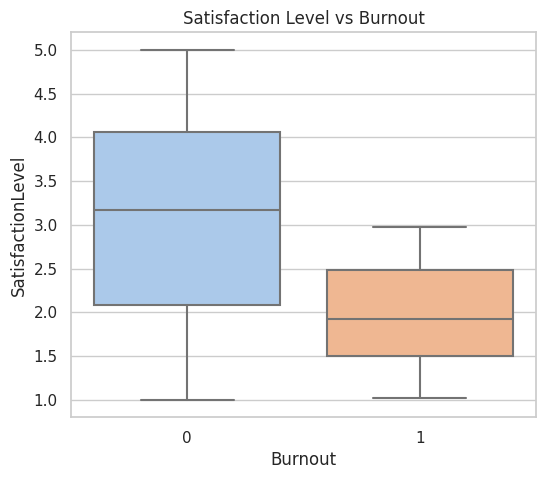

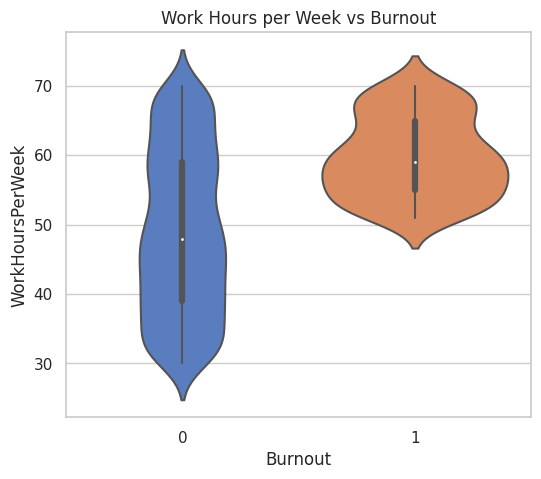

In [4]:
# Exploratory Data Analysis
## Histograms for numeric features
numeric_features = ['Age', 'Experience', 'WorkHoursPerWeek', 'SatisfactionLevel', 'StressLevel']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[feature], kde=True, bins=20, color='skyblue')
    plt.title(f'Histogram of {feature}')
plt.tight_layout()
plt.show()

## Countplot for categorical features
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Gender', palette='Set2')
plt.title('Gender Distribution')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='JobRole', palette='Set3')
plt.title('Job Role Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Correlation Heatmap for numeric columns (if 4 or more numeric columns)
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(8, 6))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()

## Box Plot for SatisfactionLevel by Burnout
plt.figure(figsize=(6, 5))
sns.boxplot(x='Burnout', y='SatisfactionLevel', data=df, palette='pastel')
plt.title('Satisfaction Level vs Burnout')
plt.show()

## Violin Plot for WorkHoursPerWeek by Burnout
plt.figure(figsize=(6, 5))
sns.violinplot(x='Burnout', y='WorkHoursPerWeek', data=df, palette='muted')
plt.title('Work Hours per Week vs Burnout')
plt.show()

In [5]:
# Predictive Modeling
# Our goal is to predict if an employee will experience burnout.
# We will use features like Age, Experience, WorkHoursPerWeek, RemoteRatio, SatisfactionLevel, and StressLevel.

# We need to encode categorical variables: Gender and JobRole
df_model = df.copy()
df_model = pd.get_dummies(df_model, columns=['Gender', 'JobRole'], drop_first=True)

# Dropping non-predictive columns such as Name
df_model.drop(['Name'], axis=1, inplace=True)

# Defining our features (X) and target variable (y)
X = df_model.drop('Burnout', axis=1)
y = df_model['Burnout']

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using Logistic Regression for prediction
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Calculating the prediction accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Prediction Accuracy: {accuracy:.4f}')

Prediction Accuracy: 0.9525


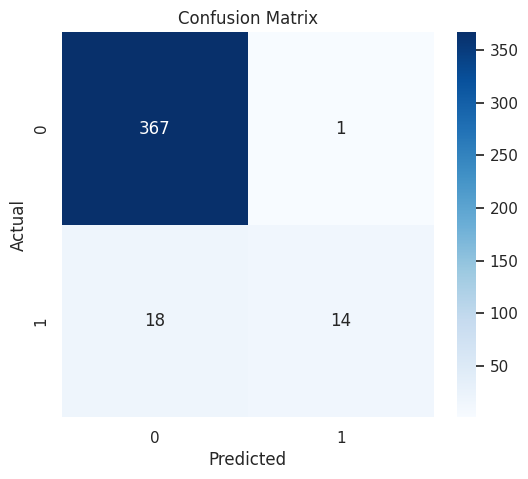

In [6]:
# Model Evaluation
# Let's create a confusion matrix to inspect the predictions in more detail
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Summary and Future Work

The notebook has taken us through an exploratory analysis of employee burnout data. We created several visualizations covering data distributions and variable relationships. Our model used a logistic regression approach to predict employee burnout, and the predictor's performance was measured using accuracy and a confusion matrix. 

One merit of this approach is its simplicity; both the EDA and the predictive modeling use conventional methods that can be easily understood and built upon. In practice, more complex models, such as ensemble methods or neural networks, might provide increased accuracy, and additional feature engineering (such as including text data from job descriptions) could yield deeper insights.

Future analyses may include:
- Investigating feature importance using permutation importance plots or SHAP values.
- Examining temporal trends if future data includes a date feature.
- Exploring the potential impact of remote work factors more intricately.

Thank you for following along. If you found this notebook useful, please consider an upvote.